# Training a model.

In this notebook, we will train a convolutional neural network for facial recognition using a technique known as transfer learning. Specifically the model will classify whether an image of a detected face is the designated celebrity or is not the designated celebrity.

Transfer learning is a technique where we can use a model pre-trained for one task, and repurpose it on a new and related task. This will allow us to achieve higher performance than training a model from scratch.

Below is a nice introduction into the definition of transfer learning, taken from the following resource: https://cs231n.github.io/transfer-learning/

 "In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest."

To implement the training of our model, we will use the PyTorch framework. Here is a reference for an example using PyTorch: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

The pre-trained model we will leverage on is Inception ResNet v1, which has been trained on the VGGFace 2 dataset. The VGGFace2 dataset consists of approximately 3.3M faces and 9000 classes. This model has been trained to extract features from face images. Here is the VGGFace2 dataset website: https://www.robots.ox.ac.uk/~vgg/data/vgg_face2/

## 1. Install requirements

In [1]:
# Mount drive.
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
!ls

gdrive	sample_data


In [3]:
# Change to your folder directory.
%cd gdrive/MyDrive/Project-1

/content/gdrive/MyDrive/Project-1


In [4]:
!pip install facenet_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.0 MB/s eta 0:00:00


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # Interactive mode.

import cv2
import copy
from facenet_pytorch import InceptionResnetV1

# 2. Load data and visualize sample images.

The dataset should be split into train and val folders, with each folder containing a folder for each class.

In [6]:
# Data augmentation and normalization for training data.
# Normalization only for validation data.
data_transforms = {
  'train': transforms.Compose([
      transforms.Resize((316, 299)),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
  'val': transforms.Compose([
      transforms.Resize((316, 299)),
      transforms.CenterCrop(299),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
}

data_dir = 'face_images'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4, drop_last=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
print(f"Number of images in train dataloader: {len(dataloaders['train'])}")
print(f"Number of images in val dataloader: {len(dataloaders['val'])}")
print(f'Class names: {class_names}')

Number of images in train dataloader: 762
Number of images in val dataloader: 155
Class names: ['not_rdj', 'rdj']


In [8]:
# Set device to GPUs if avaialable.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using " + str(device))

Using cuda


In [9]:
# Function to display images.
def imshow(inp, title=None):
  """Imshow for Tensor."""
  inp  = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std  = np.array([0.229, 0.224, 0.225])
  inp  = std * inp + mean
  inp  = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
      plt.title(title)
  plt.pause(5)  # Pause a bit so that visualizations are updated.

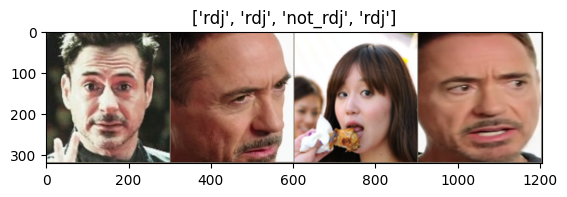

In [10]:
# Get a batch of training data.
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch.
out = torchvision.utils.make_grid(inputs)

# Visualize sampel images.
imshow(out, title=[class_names[x] for x in classes])

## 3. Train and evaluate the model.

In [11]:
# Function to train model.
def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
  since = time.time()

  #best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()  # Set model to training mode.
      else:
        model.eval()   # Set model to evaluate mode.

      running_loss = 0.0
      running_corrects = 0

      # Iterate over data.
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients.
        optimizer.zero_grad()

        # Forward pass.
        # Track history if only in train.
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          # Backpropagation only in train.
          if phase == 'train':
            loss.backward()
            optimizer.step()

          # statistics
          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)

        if phase == 'train':
          scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
          phase, epoch_loss, epoch_acc))

        # Deep copy the model.
        if phase == 'val' and epoch_acc > best_acc:
          best_acc = epoch_acc
          best_model_wts = copy.deepcopy(model.state_dict())

      print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

  return model

In [12]:
# Function to visualize model predictions on validation set.
def visualize_model(model, num_images=6):
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      print(f'preds: {preds}')

      for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images//2, 2, images_so_far)
        ax.axis('off')
        ax.set_title('predicted: {}'.format(class_names[preds[j]]))
        imshow(inputs.cpu().data[j])

        if images_so_far == num_images:
          model.train(mode=was_training)
          return
    model.train(mode=was_training)

In [13]:
# Setup model
# Specify the number of classes.
model_ft = InceptionResnetV1(pretrained='vggface2', device=device, classify= True, num_classes=len(class_names))

print(model_ft.logits)

model_ft = model_ft.to(device)

# Setup loss function.
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized.
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs.
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

  0%|          | 0.00/107M [00:00<?, ?B/s]

Linear(in_features=512, out_features=2, bias=True)


In [14]:
# Train model.
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

# Save the trained model to be used later for inference.
model_path = "trained_model.pt"
print("Saving model "+model_path);
torch.save(model_ft.state_dict(), model_path)

Streaming output truncated to the last 5000 lines.
train Loss: 0.2146 Acc: 0.6165
train Loss: 0.2148 Acc: 0.6178
train Loss: 0.2150 Acc: 0.6191
train Loss: 0.2154 Acc: 0.6205
train Loss: 0.2155 Acc: 0.6218
train Loss: 0.2161 Acc: 0.6227
train Loss: 0.2164 Acc: 0.6237
train Loss: 0.2165 Acc: 0.6250
train Loss: 0.2166 Acc: 0.6264
train Loss: 0.2168 Acc: 0.6277
train Loss: 0.2171 Acc: 0.6286
train Loss: 0.2173 Acc: 0.6300
train Loss: 0.2174 Acc: 0.6313
train Loss: 0.2185 Acc: 0.6316
train Loss: 0.2187 Acc: 0.6329
train Loss: 0.2188 Acc: 0.6342
train Loss: 0.2191 Acc: 0.6355
train Loss: 0.2194 Acc: 0.6368
train Loss: 0.2199 Acc: 0.6378
train Loss: 0.2201 Acc: 0.6391
train Loss: 0.2207 Acc: 0.6401
train Loss: 0.2215 Acc: 0.6411
train Loss: 0.2218 Acc: 0.6421
train Loss: 0.2219 Acc: 0.6434
train Loss: 0.2223 Acc: 0.6447
train Loss: 0.2226 Acc: 0.6457
train Loss: 0.2230 Acc: 0.6467
train Loss: 0.2241 Acc: 0.6477
train Loss: 0.2244 Acc: 0.6490
train Loss: 0.2246 Acc: 0.6503
train Loss: 0.2249 

preds: tensor([0, 1, 0, 0], device='cuda:0')


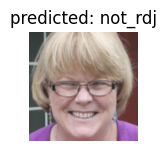

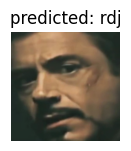

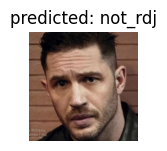

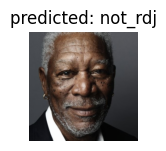

preds: tensor([0, 1, 1, 0], device='cuda:0')


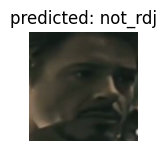

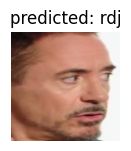

In [15]:
# Visualize model on validation data.
visualize_model(model_ft)